<a href="https://colab.research.google.com/github/MaggieHDez/ClassFiles/blob/main/PracticaReduccionNumerosidadRESUELTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ==========================================================================
# 📝 Tarea: Reducción de la Numerosidad con CNN, ENN y K-medias usando SVM
# 📊 Dataset: Breast Cancer (Scikit-Learn)
# 👤 Autor/a: [Margarita Cristina Hernández Delgadillo]
# 📅 Fecha: [21/05/2025]
# ==========================================================================

## 🔍 Descripción:
En este cuaderno aplicarás técnicas de reducción de la numerosidad (CNN, ENN, K-medias) al conjunto de datos Breast Cancer y analizarás su efecto en el rendimiento de un modelo SVM.

## ==========================================================================

## 1. Cargar librerías necesarias
Escribe aquí la importación de librerías: numpy, pandas, matplotlib, seaborn, sklearn (datasets, model_selection, preprocessing, metrics, svm, kmeans), etc.

En el caso de los códigos de ENN, CNN, estos  deberás tomarlos del cuaderno que contiene la teoría y ejemplos.

In [2]:
#1. Cargar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.datasets import load_breast_cancer
from sklearn.utils.validation import check_X_y
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.cluster import KMeans

# --------------------------------------------------------------------------

## 2. Cargar y explorar el conjunto de datos Breast Cancer
- Cargar el dataset con sklearn.datasets.load_breast_cancer
- Explora las dimensiones, variables, y distribución de clases


Dimensiones de X
 (569, 30)

Dimensiones de y
 (569,)

Variables
 Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

Tipo de variables
mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean con

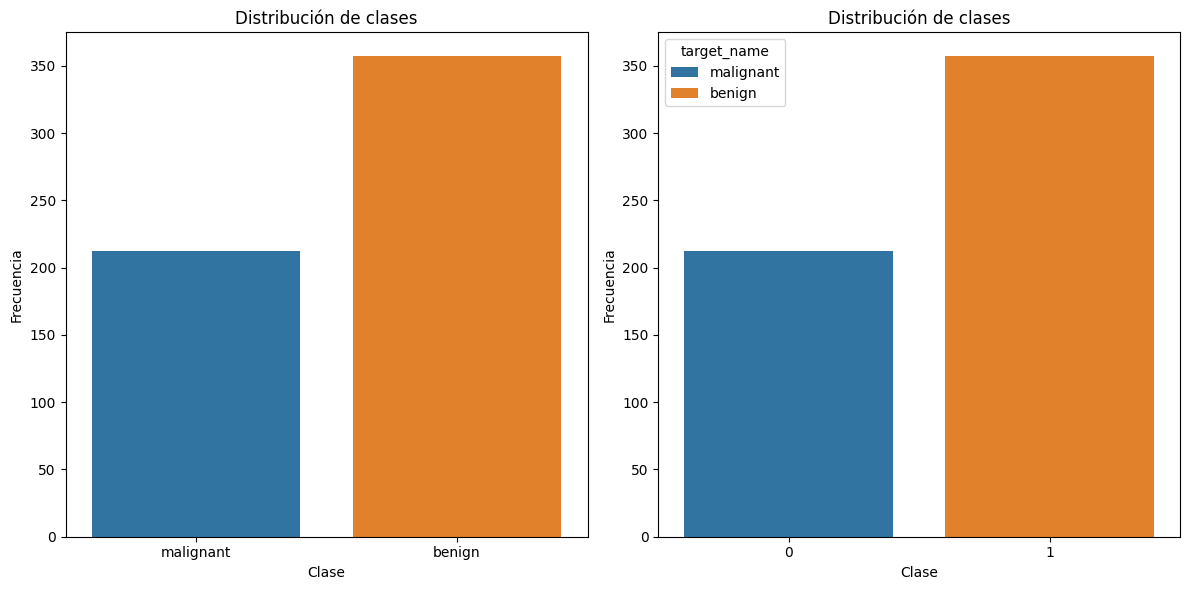

In [3]:
#2. Cargar y explorar el conjunto de datos Breast Cancer
# Carga del dataset
data = load_breast_cancer(as_frame=True)

df = data.frame

X = df.drop('target', axis=1)
y = df['target']

print('\nDimensiones de X\n', X.shape)
print('\nDimensiones de y\n', y.shape)

print('\nVariables\n', X.columns)
print('\nTipo de variables')
print(X.dtypes)

# df = pd.concat([X, y], axis=1)
mapeo = {0: 'malignant', 1: 'benign'}
df['target_name'] = df['target'].map(mapeo)

print('\nClases', df['target_name'].unique())

# Distribución de clases
#    0 = malignant, 1 = benign
clases = df['target'].value_counts()
print('\nDistribución de clases\n', clases)

# Porcentajes
clases_porc = df['target'].value_counts(normalize=True) * 100
print('\nDistribución de clases porcentual\n', clases_porc.round(2))

# Grafica de clases
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='target_name', data=df, hue='target_name')
plt.title('Distribución de clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.subplot(1, 2, 2)
sns.countplot(x='target', data=df, hue='target_name')
plt.title('Distribución de clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------

## 3. Preprocesamiento
 - Escalamiento de características (StandardScaler)
 - División del conjunto en entrenamiento y prueba
 - usar hold-out de 70% y 30%



In [4]:
# 3. Preprocesamiento
# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  División en Train/Test - Hold out 70% y 30%
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Verificación
print("Tamaño Train :", X_train.shape, y_train.value_counts(normalize=True).round(3).to_dict())
print("Tamaño Test  :", X_test.shape,  y_test.value_counts(normalize=True).round(3).to_dict())

Tamaño Train : (398, 30) {1: 0.626, 0: 0.374}
Tamaño Test  : (171, 30) {1: 0.632, 0: 0.368}


# --------------------------------------------------------------------------

## 4. Aplicar técnica CNN (Condensed Nearest Neighbor)

- Aplicar CNN sobre el conjunto de entrenamiento
- Mostrar el tamaño del conjunto reducido



In [5]:
#4. Aplicar técnica CNN (Condensed Nearest Neighbor)
class CNN:
    """
    Condensed Nearest Neighbors (CNN) - versión adaptada para datos densos.

    Este algoritmo reduce el conjunto de entrenamiento reteniendo solo
    las instancias necesarias para preservar la capacidad de clasificación
    bajo la regla 1-NN (o k-NN si se ajusta n_neighbors).

    Basado en:
    P. E. Hart, The condensed nearest neighbor rule (1968).
    """

    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
        self.classifier = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        self.sample_indices_ = []

    def select_data(self, X, y):
        # Validación de entrada: datos densos
        X, y = check_X_y(X, y, accept_sparse=False)

        idx_s = []  # índice de instancias seleccionadas
        classes = np.unique(y)
        self.classes_ = classes

        # Iniciar con una instancia aleatoria por clase
        for cur_class in classes:
            mask = np.where(y == cur_class)[0]
            choose_id = random.choice(mask)
            idx_s.append(choose_id)

        # Revisión aleatoria del resto de las instancias
        train_idx = list(range(len(y)))
        random.shuffle(train_idx)

        flag = True
        while flag:
            flag = False
            self.classifier.fit(X[idx_s], y[idx_s])
            for idx in train_idx:
                if idx not in idx_s:
                    x_i = X[idx].reshape(1, -1)
                    if self.classifier.predict(x_i) != [y[idx]]:
                        idx_s.append(idx)
                        self.classifier.fit(X[idx_s], y[idx_s])
                        flag = True

        self.X_ = X[idx_s]
        self.y_ = y[idx_s]
        self.sample_indices_ = sorted(idx_s)
        self.reduction_ = 1.0 - len(self.y_) / len(y)
        return self.X_, self.y_

Tamaño Train antes de CNN (398, 30)
Tamaño Train CNN: (65, 30)


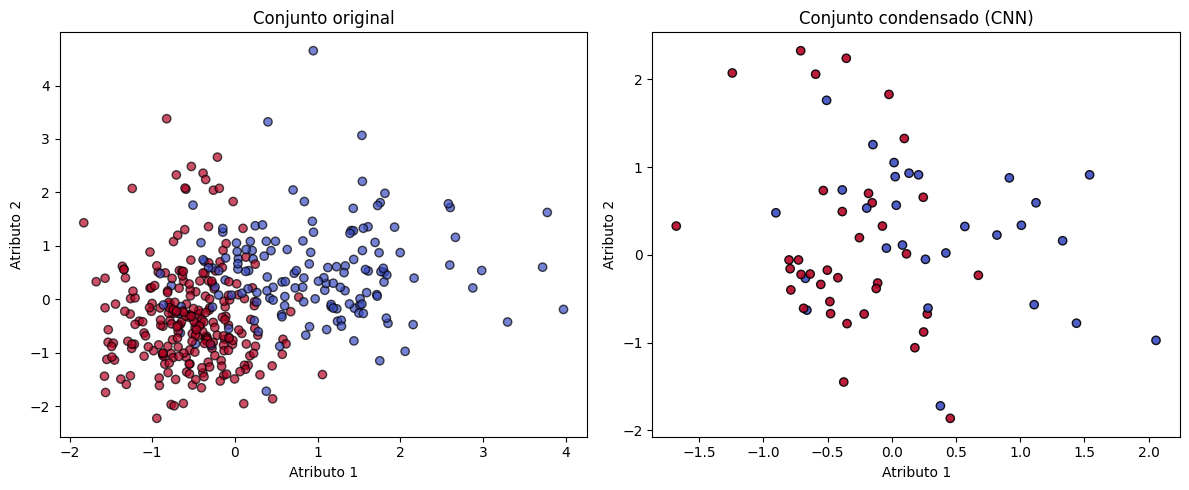

Instancias originales: 569
Instancias tras CNN:   65
Reducción: 83.67%


In [6]:
cnn = CNN()
X_train_cnn, y_train_cnn = cnn.select_data(X_train, y_train)
print('Tamaño Train antes de CNN', X_train.shape)
print("Tamaño Train CNN:", X_train_cnn.shape)

# Visualización
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.title("Conjunto original")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.subplot(1, 2, 2)
plt.scatter(X_train_cnn[:, 0], X_train_cnn[:, 1], c=y_train_cnn, cmap='coolwarm', edgecolor='k', alpha=0.9)
plt.title("Conjunto condensado (CNN)")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.tight_layout()
plt.show()

print(f"Instancias originales: {len(y)}")
print(f"Instancias tras CNN:   {len(y_train_cnn)}")
print(f"Reducción: {100 * cnn.reduction_:.2f}%")

 --------------------------------------------------------------------------

## 5. Aplicar técnica ENN (Edited Nearest Neighbor)

- Aplicar ENN sobre el conjunto de entrenamiento
- Mostrar el tamaño del conjunto reducido



In [7]:
# 5. Aplicar técnica ENN (Edited Nearest Neighbor)
class ENN:
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        self.classifier = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        self.sample_indices_ = []

    def fit(self, X, y):
        # Validación inicial
        X, y = check_X_y(X, y, accept_sparse=False)

        mask = np.ones(len(y), dtype=bool)
        tmp_m = np.ones(len(y), dtype=bool)

        indices = list(range(len(y)))
        random.shuffle(indices)

        for i in indices:
            tmp_m[i] = False
            self.classifier.fit(X[tmp_m], y[tmp_m])
            x_i = X[i].reshape(1, -1)
            y_pred = self.classifier.predict(x_i)
            if y_pred[0] != y[i]:
                mask[i] = False
            tmp_m[i] = True

        self.X_ = X[mask]
        self.y_ = y[mask]
        self.sample_indices_ = np.where(mask)[0]
        self.reduction_ = 1 - len(self.y_) / len(y)
        return self


Tamaño Train antes de ENN (398, 30)
Tamaño Train ENN: (382, 30)


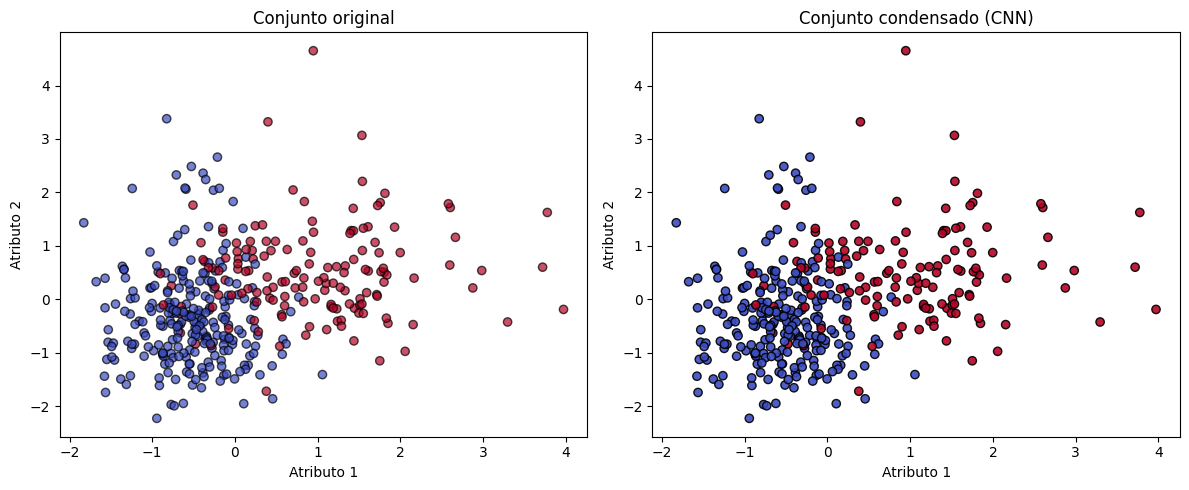

Instancias originales: 398
Instancias tras CNN:   382


In [8]:
selector = ENN()

selector.fit(X_train, y_train)
X_train_enn = selector.X_
y_train_enn = selector.y_

print('Tamaño Train antes de ENN', X_train.shape)
print("Tamaño Train ENN:", X_train_enn.shape)

# Visualización
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm_r', edgecolor='k', alpha=0.7)
plt.title("Conjunto original")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.subplot(1, 2, 2)
plt.scatter(X_train_enn[:, 0], X_train_enn[:, 1], c=y_train_enn, cmap='coolwarm_r', edgecolor='k', alpha=0.9)
plt.title("Conjunto condensado (CNN)")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.tight_layout()
plt.show()

print(f"Instancias originales: {len(y_train)}")
print(f"Instancias tras CNN:   {len(y_train_enn)}")

# --------------------------------------------------------------------------

## 6. Aplicar reducción mediante K-medias
- Realizar agrupamiento por clase y representar cada grupo con su centroide. Elige la mitad de los elementos de cada clase como el valor del número de centroides
- Generar un nuevo conjunto reducido con los centroides como prototipos



Tamaño Train antes de K-medias (398, 30)
Tamaño Train K-medias: (198, 30)


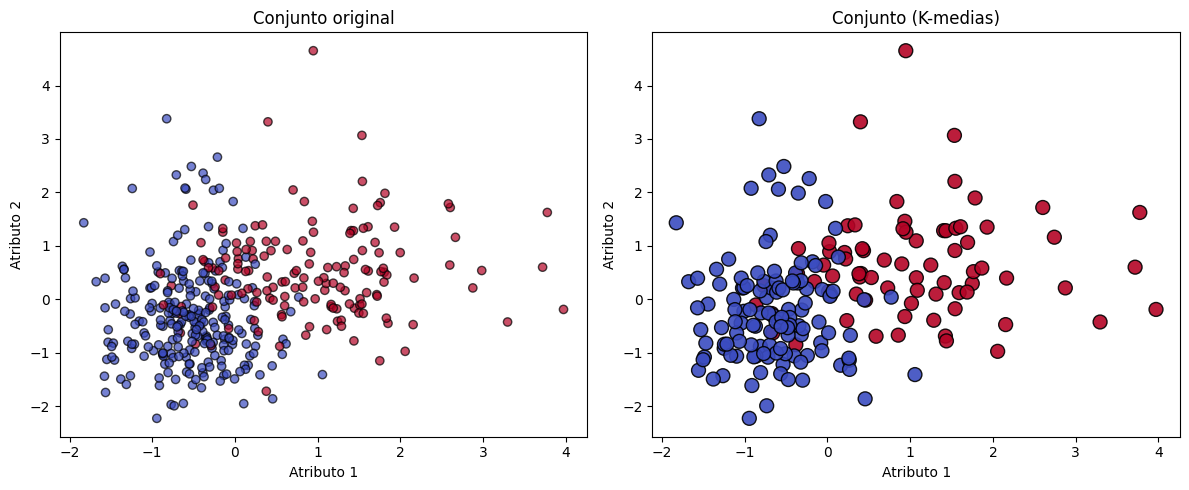

Instancias originales: 398
Instancias tras K-medias:   198


In [9]:
# 6. Aplicar reducción mediante K-medias
centroides = []
labels = []

# Agrupamiento por clase
clases = np.unique(y_train)
for clase in clases:
    mask = (y_train == clase)
    X_clase = X_train[mask]
    y_clase = y_train[mask]

    num_centroides_por_clase = max(1, len(X_clase) // 2)
    num_centroides_por_clase = min(num_centroides_por_clase, len(X_clase)) # Para que clusters no sea mayor que las muestras

    kmeans = KMeans(n_clusters=num_centroides_por_clase, random_state=42, n_init=10)
    kmeans.fit(X_clase)

    centroides.append(kmeans.cluster_centers_)
    labels.extend([clase] * num_centroides_por_clase)

X_train_kmeans = np.concatenate(centroides, axis=0)
y_train_kmeans = np.array(labels)

print('Tamaño Train antes de K-medias', X_train.shape)
print("Tamaño Train K-medias:", X_train_kmeans.shape)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm_r', edgecolor='k', alpha=0.7)
axes[0].set_title("Conjunto original")
axes[0].set_xlabel("Atributo 1")
axes[0].set_ylabel("Atributo 2")

axes[1].scatter(X_train_kmeans[:, 0], X_train_kmeans[:, 1], c=y_train_kmeans, cmap='coolwarm_r', edgecolor='k', s=100, alpha=0.9)
axes[1].set_title("Conjunto (K-medias)")
axes[1].set_xlabel("Atributo 1")
axes[1].set_ylabel("Atributo 2")

plt.tight_layout()
plt.show()

print(f"Instancias originales: {len(y_train)}")
print(f"Instancias tras K-medias:   {len(y_train_kmeans)}")

 --------------------------------------------------------------------------

##7. Entrenar SVM sobre cada conjunto reducido
- Entrenar un modelo SVM (SVC) sobre:
 * los datos originales
 * datos reducidos con CNN
 * datos reducidos con ENN
 * datos reducidos con K-medias
- Evaluar cada modelo con accuracy, F1-score



In [11]:
#7. Entrenar SVM sobre cada conjunto reducido
datos = {
    'Original': (X_train, y_train),
    'CNN': (X_train_cnn, y_train_cnn),
    'ENN': (X_train_enn, y_train_enn),
    'K-medias': (X_train_kmeans, y_train_kmeans)
}

resultados = []
clf = SVC(kernel='rbf', random_state=42)

for nombre, (X, y) in datos.items():
  # Entrenamiento
  clf.fit(X, y)

  # Evaluación
  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # Almacenar resultados
  resultados.append((nombre, accuracy, f1))

df_resultados = pd.DataFrame(resultados, columns=['Técnica', 'Accuracy', 'F1-Score'])
df_resultados.set_index('Técnica', inplace=True)
df_resultados.index.name = None
print(df_resultados)

          Accuracy  F1-Score
Original  0.970760  0.976744
CNN       0.959064  0.967442
ENN       0.964912  0.972222
K-medias  0.959064  0.968037


# --------------------------------------------------------------------------

## 📊 8. Comparar los resultados y reflexión final
- Comparar las métricas de rendimiento obtenidas con cada técnica
- Escribe tus conclusiones sobre el impacto de la reducción de la numerosidad
  - Al compara los resultados de cada modelo SVM con reducción de numerosidad con el modelo sin reducción, podemos ver que el modelo entrenado sin reducción es el que tiene mejores métricas que los otros, como se ve en la tabla. Esto se debe a que se utilizaron todos los datos al entrenar el modelo.
  
<center>

Método|Accuracy | F1-Score
--------|---------|---------
Original|0.970760|0.976744
CNN|0.959064|0.967442
ENN|0.964912|0.972222
K-medias|0.959064|0.968037

</center>

- ¿Cuál técnica funcionó mejor? ¿Qué ventajas y desventajas observaste?
  - De las técincas de reducción de numerosidad, ENN fue la que obtuvo mejores resultados con un accuracy de 0.964912 y un F1-score de 0.972222. CNN y K-medias tuvieron resultados muy similares pero un poco más bajos que ENN.
  - El reducir los datos puede hacer que el modelo sea más rápido y/o más simple, pero se puede perder precisión en comparación al entrenemaineto con los datos completos.
  - En el caso de ENN se redujo el conjunto de datos con una pequeña pérdida de rendimiento pero no fue una diferencia muy grande al accuracy y F1-score de los datos completos.
